Average delay in queue: 1.41 minutes
Average number in queue 1.49
Average number of total customers: 98.07
Servers utilization: [0.86541641 0.81995437 0.75977686 0.69123379 0.61343508]
Number of simulations 1000
----------------------------------------


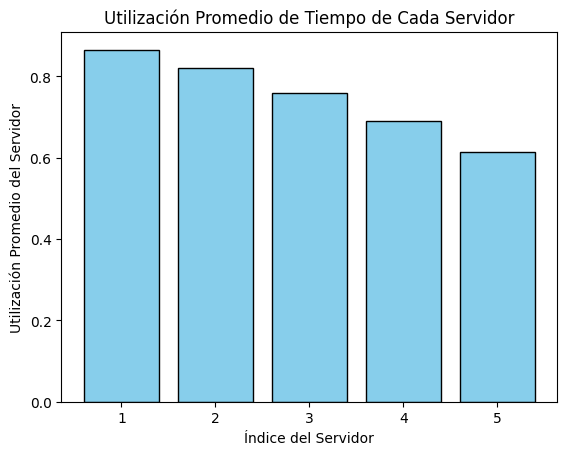

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(1)

class MM1_Queue:

    def __init__(self, num_servidores, mean_interarrival, mean_service, num_delays_required ):

        # Parámetros de entrada
        self.mean_interarrival = mean_interarrival #  Tiempo entre llegadas
        self.mean_service = mean_service # Tiempo medio de servicio
        self.num_delays_required = num_delays_required # Numero de demoras necesarias
        self.num_servidores = num_servidores # Numero de servidores

        # Variables de estado
        self.server_status = [] # 0 en idle y 1 en busy
        for i in range(0, self.num_servidores):
            self.server_status.append(0)


        self.time_last_event = 0.0
        self.num_in_q = 0
        self.time_arrival = [] # Lista para el tiempo de llegada de los compradores

        # Contadores estadísticos
        self.num_cust_delayed = 0
        self.total_of_delays = 0.0
        self.area_num_in_q = 0.0
        self.area_server_status = []
        for i in range(0, self.num_servidores):
          self.area_server_status.append(0.0)

        # Reloj de simulación
        self.sim_time = 0.0

        # Lista de eventos
        self.time_next_event = [0]
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)
        for i in range(0, self.num_servidores):
          self.time_next_event.append(float('inf'))

        self.server_event = []
        for i in range(0, self.num_servidores):
          self.server_event.append(None)

    def main(self):

        # Corre la simulación mientras se necesiten más demoras
        while (self.sim_time < self.num_delays_required):

            # Determina cuál es el próximo evento
            self.timing()
            # Actualiza las estadísticas
            self.update_time_avg_stats()
            # Llama la función que le corresponde al evento (tipo 1 es llegada y tipo 2 partida)
            if (self.next_event_type == 1):
                self.arrive()
            elif (self.next_event_type == 2):
                self.depart()
            else:
                break


    def timing(self):

        # Variables necesarias para buscar en la lista de eventos el tiempo mínimo
        self.min_time_next_event = float('inf')
        self.next_event_type = 0

        # Determina el tipo de evento que ocurrirá en cada sistema
        for i in range(0, self.num_servidores + 1):

            if(self.time_next_event[i] < self.min_time_next_event):
                self.min_time_next_event = self.time_next_event[i]
                if (i > 0):
                    self.next_event_type = 2
                else:
                    self.next_event_type = 1

        # Verificar si todos los eventos de la lista tienen valor infinito para detener la simulación
        if (self.next_event_type == 0) :
            raise Exception ("All entries in the event list have infinite values, so stop the simulation")

        # Si algun valor en la lista es finito, avanza el reloj de simulación
        self.sim_time = self.min_time_next_event

    def arrive(self):

        # Programar la próxima llegada
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)

        # Verificar disponibilidad de los servidores
        self.available_server = None
        for i, status in enumerate(self.server_status):
            if status == 0:
                self.available_server = i
                break

        if self.available_server is not None:

            # Asignar cliente al servidor disponible y marcarlo como ocupado
            self.server_status[self.available_server] = 1
            self.num_cust_delayed += 1

            # Programar evento de partida para ese servidor
            self.time_next_event[self.available_server + 1] = self.sim_time + self.expon(self.mean_service)

            # Actualizar para reflejar esta nueva asignación
            self.server_event[self.available_server] = 1

        else:
                # Se forma una cola
                self.num_in_q += 1
                self.time_arrival.append(self.sim_time)



    def depart(self):

        for i, server in enumerate(self.server_event):

            if server is not None and self.time_next_event[i + 1] == self.sim_time:
                # Marcar el servidor como libre
                self.server_status[i] = 0

                # Asegurar que no hay más eventos de partida programados para ese servidor
                self.time_next_event[i + 1] = float('inf')
                self.server_event[i] = None

                if self.num_in_q > 0:

                    # Hay clientes en espera, asigna el siguiente en la cola a ese servidor
                    self.num_in_q -= 1
                    self.server_status[i] = 1

                    self.delay = self.sim_time - self.time_arrival[0]
                    self.total_of_delays += self.delay

                    # Incrementa el número de clientes retrasados y agenda una partida
                    self.num_cust_delayed += 1
                    self.time_next_event[i + 1] = self.sim_time + self.expon(self.mean_service)
                    self.server_event[i] = 1  # Indicar que este servidor ahora está ocupado con un nuevo cliente

                    # Elimina el cliente que está de primeras en la fila
                    del self.time_arrival [0]

                # Si no hay clientes en espera, simplemente se libera la bomba y se espera el próximo evento
                break

    def update_time_avg_stats(self):

        #Calcula el tiempo desde el último evento
        self.time_since_last_event = self.sim_time - self.time_last_event
        self.time_last_event = self.sim_time

        # Actualiza el área bajo la curva de la variable número en cola
        self.area_num_in_q += self.num_in_q * self.time_since_last_event

        for i in range(0, self.num_servidores):
            self.area_server_status[i] += self.server_status[i] * self.time_since_last_event

    def expon(self, mean):

        return (-mean * np.log(np.random.uniform(0,1)))

def perform_simulation(num_servidores, mean_interarrival, mean_service, num_delays_required, num_simulations):
    total_delays = []
    total_customers = []
    avg_num_in_queue_list = []
    server_utilizations = np.zeros((num_simulations, num_servidores))

    for sim in range(num_simulations):
        model = MM1_Queue(num_servidores, mean_interarrival, mean_service, num_delays_required)
        model.main()
        total_delays.append(model.total_of_delays / model.num_cust_delayed if model.num_cust_delayed > 0 else 0)
        total_customers.append(model.num_cust_delayed)
        avg_num_in_queue_list.append(model.area_num_in_q / model.sim_time)

        for i in range(num_servidores):
            server_utilizations[sim, i] = model.area_server_status[i] / model.sim_time

    avg_delay = np.mean(total_delays)
    avg_customers_served = np.mean(total_customers)
    avg_server_utilization = np.mean(server_utilizations, axis=0)
    avg_num_in_queue = np.mean(avg_num_in_queue_list)

    return avg_delay, avg_customers_served, avg_server_utilization, avg_num_in_queue

# Configuración de parámetros de simulación
num_servidores = 5
mean_interarrival = 1
mean_service = 4
num_delays_required = 1000
num_simulations = 1000

# Ejecutar la simulación
avg_delay, avg_customers_served, avg_server_utilization, avg_num_in_queue = perform_simulation(num_servidores, mean_interarrival, mean_service, num_delays_required, num_simulations)


# Mostrar resultados
print(f"Average delay in queue: {avg_delay:.2f} minutes")
print(f"Average number in queue {avg_num_in_queue:.2f}")
print(f"Average number of total customers: {avg_customers_served}")
print("Servers utilization:", avg_server_utilization)
print(f"Number of simulations {num_simulations}")
print("-" * 40)

server_indices = range(1, num_servidores + 1)
plt.bar(server_indices, avg_server_utilization, color='skyblue', edgecolor='black')
plt.xlabel('Índice del Servidor')
plt.ylabel('Utilización Promedio del Servidor')
plt.title('Utilización Promedio de Tiempo de Cada Servidor')
plt.xticks(server_indices)
plt.show()